In [4]:
import tensorflow as tf
from skimage.color import gray2rgb,convert_colorspace
from skimage.transform import resize
from skimage.io import imread_collection
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imread_collection
import os
from scipy.spatial.distance import correlation
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import random

In [5]:
#########################################    AutoEncoder Data Creation #########################################################

directories = ['animal/*.JPEG', 'plant/*.JPEG', 'fungus/*.JPEG', 'geological/*.JPEG', 'person/*.JPEG', 'sport/*.JPEG']
target = []
all_auto = []
for j in range(0, len(directories)):
    col = imread_collection(directories[j])
    #print(j, 'size of folder', len(col))
    if(j==0):
        target1 = [0] * len(col)
    elif(j==1):
        target1 = [1] * len(col)
    elif(j==2):
        target1 = [2] * len(col)
    elif(j==3):
        target1 = [3] * len(col)
    elif(j==4):
        target1 = [4] * len(col)
    elif(j==5):
        target1 = [5] * len(col)

    for i in range(0, len(col)):        
        x = col[i]
        
        #for grayscale images
        if(len(x.shape)==2):
            x = gray2rgb(x)
        x = x.astype('float32') / 255.
        x_resized = resize(x, (64, 64, 3))
        
        all_auto.append(x_resized)
    target = target+ target1    

auto_feature_vector = np.array(all_auto)

X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(auto_feature_vector, target, test_size = 0.20, random_state=0)
print('Done')

Done


In [3]:
#########################################    AutoEncoder Creation ##############################################################

# adapt this if using `channels_first` image data format
input_img = Input(shape=(64, 64, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
#print(encoded.shape)

# representation here is (64, 64, 32)
 
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
#print(decoded.shape)

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_logarithmic_error', metrics=['accuracy', 'mse'])

history = autoencoder.fit(X_train_auto, X_train_auto,
                epochs=5,
                batch_size=719,
                shuffle=True,
                validation_data=(X_test_auto, X_test_auto),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

#feature vector creation
train_encoded = encoder.predict(X_train_auto)
test_encoded = encoder.predict(X_test_auto)
train = []
test = []
for i in range(0, train_encoded.shape[0]):
    train.append(train_encoded[i].flatten('C'))
for i in range(0, test_encoded.shape[0]):
    test.append(test_encoded[i].flatten('C'))

training_vec = np.array(train)
testing_vec = np.array(test)
print('Done')

Train on 7189 samples, validate on 1798 samples
Epoch 1/5
7189/7189 [==============================] - 131s - loss: 0.0404 - acc: 0.3833 - mean_squared_error: 0.0785 - val_loss: 0.0393 - val_acc: 0.4818 - val_mean_squared_error: 0.0772

In [6]:
#########################################    Singular Value Decomposition ######################################################

directories = ['animal/*.JPEG', 'plant/*.JPEG', 'fungus/*.JPEG', 'geological/*.JPEG', 'person/*.JPEG', 'sport/*.JPEG']
target_svd = []
all_svd = []
for j in range(0,len(directories)):
    col = imread_collection(directories[j])
    if(j==0):
        target1 = [0] * len(col)
    elif(j==1):
        target1 = [1] * len(col)
    elif(j==2):
        target1 = [2] * len(col)
    elif(j==3):
        target1 = [3] * len(col)
    elif(j==4):
        target1 = [4] * len(col)
    elif(j==5):
        target1 = [5] * len(col)
    
    for i in range(0,len(col)):
        x = col[i]
        if len(x.shape) == 2:
            x = gray2rgb(x)
        x_resized = resize(x, (64,64,3))    
        
        x_flat = x_resized.flatten('F')        
        all_svd.append(x_flat)
    target_svd = target_svd + target1
    
all_svd = np.matrix(all_svd)
svd = TruncatedSVD(n_components=500)
all_svd = svd.fit_transform(all_svd)

In [8]:
######################################### RGB and HSV Histogram Creation ########################################################

directories = ['animal/*.JPEG', 'plant/*.JPEG', 'fungus/*.JPEG', 'geological/*.JPEG', 'person/*.JPEG', 'sport/*.JPEG']
target = []
all_rgb = []
all_hsv = []
for j in range(0,len(directories)):
    col = imread_collection(directories[j])
    if(j==0):
        target1 = [0] * len(col)
    elif(j==1):
        target1 = [1] * len(col)
    elif(j==2):
        target1 = [2] * len(col)
    elif(j==3):
        target1 = [3] * len(col)
    elif(j==4):
        target1 = [4] * len(col)
    elif(j==5):
        target1 = [5] * len(col)
    
    for i in range(0,len(col)):
        x = col[i]
        
        #converting grayscale to rgb image
        if len(x.shape) == 2:
            x = gray2rgb(x)
        x_resized = resize(x, (64,64,3))
        
        #making rgb histogram
        red = x_resized[:,:,0]
        red=np.reshape(red, (64*64,1))
        red_hist = np.histogram(red,bins=256)
        
        green = x_resized[:,:,1]
        green=np.reshape(green, (64*64,1))
        green_hist = np.histogram(green,bins=256)
        
        blue = x_resized[:,:,2]
        blue=np.reshape(blue, (64*64,1))
        blue_hist = np.histogram(blue,bins=256)
        
        fv = np.concatenate((red_hist[0],blue_hist[0]),axis=0)
        feature_vector = np.concatenate((fv,green_hist[0]),axis=0)
        
        all_rgb.append(feature_vector)
        
        
        #making hsv histogram
        img_hsv = convert_colorspace(x_resized, 'RGB', 'HSV')
    
        h = img_hsv[:,:,0]
        h=np.reshape(h, (64*64,1))
        h_hist = np.histogram(h,bins=180)
        
        s = img_hsv[:,:,1]
        s=np.reshape(s, (64*64,1))
        s_hist = np.histogram(s,bins=256)
        
        v = img_hsv[:,:,2]
        v=np.reshape(v, (64*64,1))
        v_hist = np.histogram(v,bins=256)
        
        fv1 = np.concatenate((h_hist[0],s_hist[0]),axis=0)
        feature_vector1 = np.concatenate((fv1,v_hist[0]),axis=0)
        
        all_hsv.append(feature_vector1)
        
    target = target + target1
print('Done')

Done


In [10]:
######################################### Calculating 5NN distances ############################################################

#splitting data into 80-20
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(all_rgb, target, test_size=0.20, random_state=0)
X_train_hsv, X_test_hsv, y_train_hsv, y_test_hsv = train_test_split(all_hsv, target, test_size=0.20, random_state=0)
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(all_svd, target_svd, test_size=0.20, random_state=0)

#calculating 5NN of each auto image using Euclidean Distance
print ("Calculating Euclidean distance of Auto image")
nbrs = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(training_vec)
euc_distances_auto, euc_indices_auto = nbrs.kneighbors(testing_vec)
print (euc_indices_auto)
print ("")

#calculating 5NN of each auto image using Pearson Correlation
print ("Calculating Pearson distance of Auto image")
nbrs = NearestNeighbors(n_neighbors=5, metric='correlation',algorithm='brute').fit(training_vec)
pear_distances_auto, pear_indices_auto = nbrs.kneighbors(testing_vec)
print (pear_indices_auto)
print ("")

#calculating 5NN of each SVD image using Euclidean Distance
print ("Calculating Euclidean distance of SVD image")
nbrs = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(X_train_svd)
euc_distances_svd, euc_indices_svd = nbrs.kneighbors(X_test_svd)
print (euc_indices_svd)
print ("")

#calculating 5NN of each SVD image using Pearson Correlation Coefficient
print ("Calculating Pearson distance of SVD image")
nbrs = NearestNeighbors(n_neighbors=5, metric='correlation',algorithm='brute').fit(X_train_svd)
pear_distances_svd, pear_indices_svd = nbrs.kneighbors(X_test_svd)
print (pear_indices_svd)
print ("")

#calculating 5NN of each RGB image using Euclidean distance
print ("Calculating Euclidean distance of RGB image")
nbrs = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(X_train_rgb)
euc_distances_rgb, euc_indices_rgb = nbrs.kneighbors(X_test_rgb)
print (euc_indices_rgb)
print ("")

#calculating 5NN of each RGB image using Pearson Correlation Coefficient
print ("Calculating Pearson distance of RGB image")
nbrs = NearestNeighbors(n_neighbors=5, metric='correlation',algorithm='brute').fit(X_train_rgb)
pear_distances_rgb, pear_indices_rgb = nbrs.kneighbors(X_test_rgb)
print (pear_indices_rgb)
print ("")

#calculating 5NN of each HSV image using Euclidean distance
print ("Calculating Euclidean distance of HSV image")
nbrs = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(X_train_hsv)
euc_distances_hsv, euc_indices_hsv = nbrs.kneighbors(X_test_hsv)
print (euc_indices_hsv)
print ("")

#calculating 5NN of each HSV image using Pearson Correlation Coefficient
print ("Calculating Pearson distance of HSV image")
nbrs = NearestNeighbors(n_neighbors=5, metric='correlation',algorithm='brute').fit(X_train_hsv)
pear_distances_hsv, pear_indices_hsv = nbrs.kneighbors(X_test_hsv)
print (pear_indices_hsv)
print ("")

Calculating Euclidean distance of Auto image
[[3794 4718 5057 6778 5667]
 [3267 2723 7081 1355 4903]
 [5124 5421 3556  109  787]
 ..., 
 [3992 1733 3201 4565  210]
 [4908 2372  443 3426 4086]
 [4785 2325 5054 4071 5371]]

Calculating Pearson distance of Auto image
[[3794 4718  500 5667 1794]
 [4683 4225 2822 3178 1294]
 [4225 5559 3556 6977  787]
 ..., 
 [3992  408  468 3201 4204]
 [4454 4908 1814 3426 2372]
 [4899 5054 4785 2325 3879]]

Calculating Euclidean distance of SVD image
[[4718 3794 5057 5098 1794]
 [3267 2754 3923  880 7081]
 [5559 4903 4225 6617 4543]
 ..., 
 [2003 4166 2326  286 6402]
 [4086 6379 5823 4908 2514]
 [3879 4030 4133 3094 5054]]

Calculating Pearson distance of SVD image
[[3794  500 4718 1006 5667]
 [4683  142 7028 5435  865]
 [5559 4903  787 4225 4683]
 ..., 
 [1953 1091 6528 6196 4815]
 [4454 4086 6774 3521 2514]
 [4133 3879 4030 5382 5054]]

Calculating Euclidean distance of RGB image
[[2706 3387 1636 1528  995]
 [3213 3035  586 5476 3267]
 [7142 2588 3557 3

In [11]:
######################################### Determining category of each image ###################################################

#Auto Euc
print ("finding category of auto image using euclidean distance")
final_cat_auto_euc = []
for i in range(0,len(euc_indices_auto)):
    alist = []
    for j in range(0,5):
        alist.append(y_train_auto[euc_indices_auto[i][j]])
    final_cat_auto_euc.append(mode(alist)[0][0])
#print (final_cat_auto_euc)

#Auto Pear
print ("finding category of auto image using pearson correlation")
final_cat_auto_pear = []
for i in range(0,len(pear_indices_auto)):
    alist = []
    for j in range(0,5):
        alist.append(y_train_auto[pear_indices_auto[i][j]])
    final_cat_auto_pear.append(mode(alist)[0][0])
#print (final_cat_auto_pear)

#SVD Euc
print ("finding category of SVD image using euclidean distance")
final_cat_svd_euc = []
for i in range(0,len(euc_indices_svd)):
    alist = []
    for j in range(0,5):
        alist.append(y_train_svd[euc_indices_svd[i][j]])
    final_cat_svd_euc.append(mode(alist)[0][0])
#print (final_cat_svd_euc)

#SVD Pear
print ("finding category of SVD image using pearson correlation")
final_cat_svd_pear = []
for i in range(0,len(pear_indices_svd)):
    alist = []
    for j in range(0,5):
        alist.append(y_train_svd[pear_indices_svd[i][j]])
    final_cat_svd_pear.append(mode(alist)[0][0])
#print (final_cat_svd_pear)

#RGB Euc
print ("finding category of RGB image using euclidean distance")
final_cat_rgb_euc = []
for i in range(0,len(euc_indices_rgb)):
    alist = []
    for j in range(0,5):
        alist.append(y_train_rgb[euc_indices_rgb[i][j]])
    final_cat_rgb_euc.append(mode(alist)[0][0])
#print (final_cat_rgb_euc)

#RGB Pear
print ("finding category of RGB image using pearson correlation")
final_cat_rgb_pear = []
for i in range(0,len(pear_indices_rgb)):
    alist = []
    for j in range(0,5):
        alist.append(y_train_rgb[pear_indices_rgb[i][j]])
    final_cat_rgb_pear.append(mode(alist)[0][0])
#print (final_cat_rgb_pear)

#HSV Euc
print ("finding category of HSV image using euclidean distance")
final_cat_hsv_euc = []
for i in range(0,len(euc_indices_hsv)):
    alist = []
    for j in range(0,5):
        alist.append(y_train_hsv[euc_indices_hsv[i][j]])
    final_cat_hsv_euc.append(mode(alist)[0][0])
#print (final_cat_hsv_euc)

#HSV Pear
print ("finding category of HSV image using pearson correlation")
final_cat_hsv_pear = []
for i in range(0,len(pear_indices_hsv)):
    alist = []
    for j in range(0,5):
        alist.append(y_train_hsv[pear_indices_hsv[i][j]])
    final_cat_hsv_pear.append(mode(alist)[0][0])
#print (final_cat_hsv_pear)

finding category of auto image using euclidean distance
finding category of auto image using pearson correlation
finding category of SVD image using euclidean distance
finding category of SVD image using pearson correlation
finding category of RGB image using euclidean distance
finding category of RGB image using pearson correlation
finding category of HSV image using euclidean distance
finding category of HSV image using pearson correlation


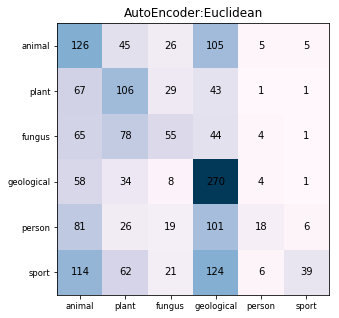

Accuracy of Auto Euc
0.34149054505


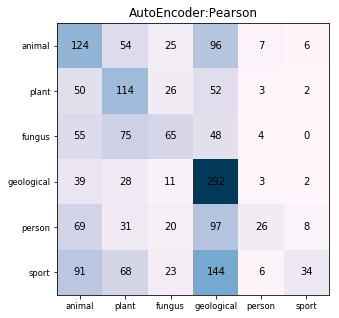

Accuracy of Auto Pearson
0.364293659622


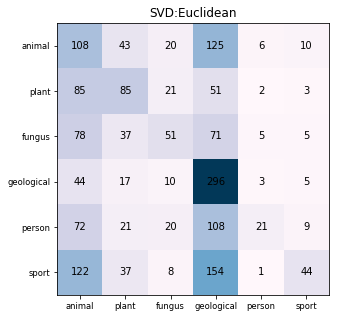

Accuracy of SVD Euc
0.336484983315


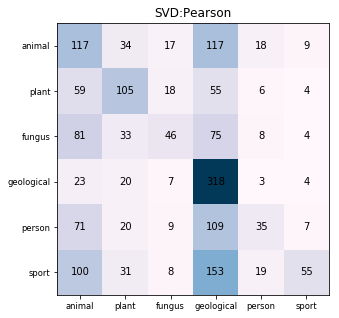

Accuracy of SVD Pearson
0.375973303671


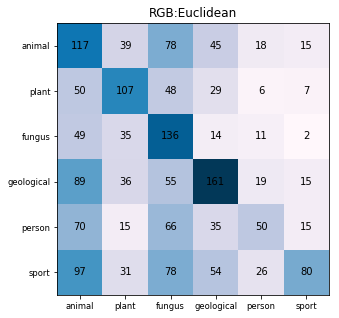

Accuracy of RGB Euc
0.362068965517


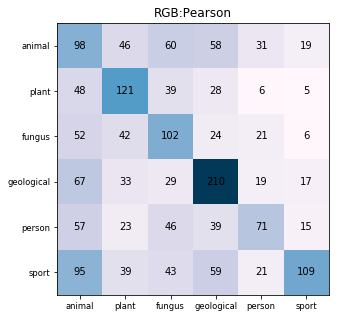

Accuracy of RGB Pearson
0.395439377086


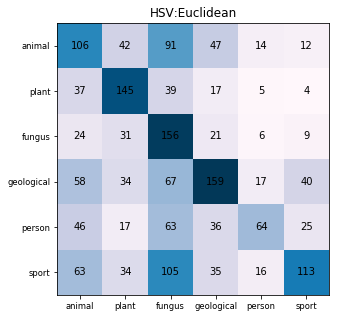

Accuracy of HSV Euc
0.413236929922


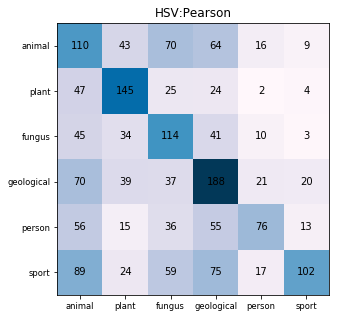

Accuracy of HSV Pearson
0.408787541713


In [12]:
######################################### Creating Confusion Matrices ###########################################################

#Auto Euc confusion matrix
cf_auto_euc = confusion_matrix(y_test_auto,final_cat_auto_euc)
labels = ['animal', 'plant', 'fungus', 'geological', 'person', 'sport']
plt.figure(figsize=(5, 5))
plt.imshow(cf_auto_euc, cmap = 'PuBu')
for y in range(6):
    for x in range(6):
        plt.text(x , y, cf_auto_euc[y][x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.xticks(range(len(cf_auto_euc)), labels, size='small')
plt.yticks(range(len(cf_auto_euc)), labels, size='small')
plt.title('AutoEncoder:Euclidean')
plt.show()
print ("Accuracy of Auto Euc")
print (accuracy_score(y_test_auto,final_cat_auto_euc))

#Auto Pearson confusion matrix
cf_auto_pear = confusion_matrix(y_test_auto,final_cat_auto_pear)
labels = ['animal', 'plant', 'fungus', 'geological', 'person', 'sport']
plt.figure(figsize=(5, 5))
plt.imshow(cf_auto_pear, cmap = 'PuBu')
for y in range(6):
    for x in range(6):
        plt.text(x , y, cf_auto_pear[y][x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.xticks(range(len(cf_auto_pear)), labels, size='small')
plt.yticks(range(len(cf_auto_pear)), labels, size='small')
plt.title('AutoEncoder:Pearson')
plt.show()
print ("Accuracy of Auto Pearson")
print (accuracy_score(y_test_auto,final_cat_auto_pear))

#SVD Euc confusion matrix
cf_svd_euc = confusion_matrix(y_test_svd,final_cat_svd_euc)
labels = ['animal', 'plant', 'fungus', 'geological', 'person', 'sport']
plt.figure(figsize=(5, 5))
plt.imshow(cf_svd_euc, cmap = 'PuBu')
for y in range(6):
    for x in range(6):
        plt.text(x , y, cf_svd_euc[y][x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.xticks(range(len(cf_svd_euc)), labels, size='small')
plt.yticks(range(len(cf_svd_euc)), labels, size='small')
plt.title('SVD:Euclidean')
plt.show()
print ("Accuracy of SVD Euc")
print (accuracy_score(y_test_svd,final_cat_svd_euc))

#SVD Pearson confusion matrix
cf_svd_pear = confusion_matrix(y_test_svd,final_cat_svd_pear)
labels = ['animal', 'plant', 'fungus', 'geological', 'person', 'sport']
plt.figure(figsize=(5, 5))
plt.imshow(cf_svd_pear, cmap = 'PuBu')
for y in range(6):
    for x in range(6):
        plt.text(x , y, cf_svd_pear[y][x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.xticks(range(len(cf_svd_pear)), labels, size='small')
plt.yticks(range(len(cf_svd_pear)), labels, size='small')
plt.title('SVD:Pearson')
plt.show()
print ("Accuracy of SVD Pearson")
print (accuracy_score(y_test_svd,final_cat_svd_pear))

#RGB Euc confusion matrix
cf_rgb_euc = confusion_matrix(y_test_rgb,final_cat_rgb_euc)
labels = ['animal', 'plant', 'fungus', 'geological', 'person', 'sport']
plt.figure(figsize=(5, 5))
plt.imshow(cf_rgb_euc, cmap = 'PuBu')
for y in range(6):
    for x in range(6):
        plt.text(x , y, cf_rgb_euc[y][x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.xticks(range(len(cf_rgb_euc)), labels, size='small')
plt.yticks(range(len(cf_rgb_euc)), labels, size='small')
plt.title('RGB:Euclidean')
plt.show()
print ("Accuracy of RGB Euc")
print (accuracy_score(y_test_rgb,final_cat_rgb_euc))

#RGB Pearson confusion matrix
cf_rgb_pear = confusion_matrix(y_test_rgb,final_cat_rgb_pear)
labels = ['animal', 'plant', 'fungus', 'geological', 'person', 'sport']
plt.figure(figsize=(5, 5))
plt.imshow(cf_rgb_pear, cmap = 'PuBu')
for y in range(6):
    for x in range(6):
        plt.text(x , y, cf_rgb_pear[y][x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.xticks(range(len(cf_rgb_pear)), labels, size='small')
plt.yticks(range(len(cf_rgb_pear)), labels, size='small')
plt.title('RGB:Pearson')
plt.show()
print ("Accuracy of RGB Pearson")
print (accuracy_score(y_test_rgb,final_cat_rgb_pear))

#HSV Euc confusion matrix
cf_hsv_euc = confusion_matrix(y_test_hsv,final_cat_hsv_euc)
labels = ['animal', 'plant', 'fungus', 'geological', 'person', 'sport']
plt.figure(figsize=(5, 5))
plt.imshow(cf_hsv_euc, cmap = 'PuBu')
for y in range(6):
    for x in range(6):
        plt.text(x , y, cf_hsv_euc[y][x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.xticks(range(len(cf_hsv_euc)), labels, size='small')
plt.yticks(range(len(cf_hsv_euc)), labels, size='small')
plt.title('HSV:Euclidean')
plt.show()
print ("Accuracy of HSV Euc")
print (accuracy_score(y_test_hsv,final_cat_hsv_euc))

#HSV Pearson confusion matrix
cf_hsv_pear = confusion_matrix(y_test_hsv,final_cat_hsv_pear)
labels = ['animal', 'plant', 'fungus', 'geological', 'person', 'sport']
plt.figure(figsize=(5, 5))
plt.imshow(cf_hsv_pear, cmap = 'PuBu')
for y in range(6):
    for x in range(6):
        plt.text(x , y, cf_hsv_pear[y][x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.xticks(range(len(cf_hsv_pear)), labels, size='small')
plt.yticks(range(len(cf_hsv_pear)), labels, size='small')
plt.title('HSV:Pearson')
plt.show()
print ("Accuracy of HSV Pearson")
print (accuracy_score(y_test_hsv,final_cat_hsv_pear))


REPORT

This part of the assignment deals with the ImageNet collection of images, concerning 6 categories namely Plants, Geological formations, fungus, sports, Person and Animals. These images have to be converted into vectors and then using Euclidean and Pearson Correlation, the 5 nearest neighbors are found and accuracy of the methods are judged.

The first technique used is an AutoEncoder. The images have been first resized to 64 x 64 x 3. 
- 2 convolutional and 1 Max Pooling layers are used for encoding the image with the 'relu' activation. Size now becomes 64 x 64 x 32
- 3 convolutional and 2 Up Sampling layers are used for decoding the image with 'relu' and 'sigmoid' activations.
- The autoencoder then uses the 'adadelta' optimizer and 'mean_squared_logarithmic_error' loss function. 
- After training it with 5 epochs, the accuracy reaches 52%. 
This accuracy is low compared to the models' working on MNIST dataset. This is because, the ImageNet data images are much larger (64 x 64) compared to MNIST (28 x 28), they are 3D instead of 1D and to work equally well on these images, many more number of convolutional layers would need to be added. Due to computational constraints of the machine, I have used just 2-3 layers and hence, the accuracy is not very high.

The second technique used is Singular Value Decomposition (SVD). SVD is used to reduce the dimensionality of the image for easier processing. 
- I am using the TruncatedSVD from sklearn library with the new dimension size set to 500 as this performs the best.
- The accuracy after finding 5NN using Euclidean distance is 33.65% and with Pearson Correlation Coefficient it is 37.6%
Pearson correlation coefficient is a type of correlation measure and thus does not vary with scaling whereas Euclidean distance can vary as images are resized. Since the data we are dealing with has been resized to smaller sizes, pearson distances work better and thus it is giving higher accuracy as the working of this new image in comparison with the original image is more closer than when using Euclidean distances.

The third technique used is RGB histogram creation. 
- Grayscale images have first been converted to RGB and then resized. 
- Each of the red, green and blue channels have been extracted, reshaped and then made into a histogram with 256 bins corresponding to the 256 values possible in the channel. 
- The accuracy after finding 5NN using Euclidean distance is 36.2% and with Pearson Correlation Coefficient it is 39.54%
The reason that Pearson is working better than Euclidean is the same as above. On the whole the accuracy is low however due to the fact that RGB representation is not a good measure of how close images are because the actual color of the pixel isn't being considered but instead the R, G and B values are compared which can vary greatly across pixels. Different combinations of these channels can result in the same color and so it is not very accurate.

The fourth technique used is HSV histogram creation.
- Grayscale images have first been converted to RGB and then HSV and then resized. 
- Each of the hue, saturation and value channels have been extracted, reshaped and then made into a histogram with 180, 256 and 256 bins corresponding to the values possible in the channel. 
- The accuracy after finding 5NN using Euclidean distance is 41.32% and with Pearson Correlation Coefficient it is 40.88%
The reason that Pearson is working better than Euclidean is the same as above. HSV in general performs better than RGB because it closely resembles human perception of colors. If the distance between RGB images is less, it does not necessarily mean that the images are very similar but the same with HSV definitely means that the images are visually similar. This is why it performs with better accuracy.